Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
 98% 97.0M/98.8M [00:00<00:00, 1.01GB/s]
100% 98.8M/98.8M [00:00<00:00, 987MB/s] 
Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1088s 396ms/step - accuracy: 0.8248 - loss: 0.6914 - val_accuracy: 0.8276 - val_loss: 0.6749 - learning_rate: 5.0000e-04
Epoch 2/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1132s 407ms/step - accuracy: 0.8279 - loss: 0.6408 - val_accuracy: 0.8282 - val_loss: 0.5818 - learning_rate: 5.0000e-04
Epoch 3/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1086s 397ms/step - accuracy: 0.8354 - loss: 0.5587 - val_accuracy: 0.8650 - val_loss: 0.5255 - learning_rate: 5.0000e-04
Epoch 4/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1086s 397ms/step - accuracy: 0.8358 - loss: 0.6317 - val_accuracy: 0.8326 - val_loss: 0.6242 - learning_rate: 5.0000e-04
Epoch 5/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1125s 405ms/step - accuracy: 0.8418 - loss: 0.5552 - val_accuracy: 0.9074 - val_loss: 0.3617 - learning_rate: 5.0000e-04
Epoch 6/15
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 1149s 400ms/step - accuracy: 0.8994 - loss: 0.3650 - val_accuracy: 0.8839 - val_loss: 0.3962 - learning_rate: 5.0000e-04
Epoch 7/15
2737/2737 ━

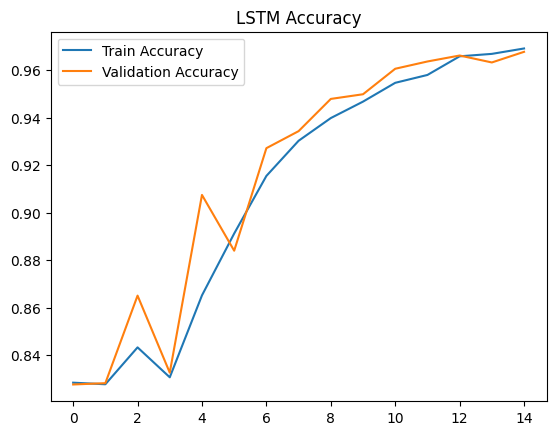


Classification Report:
              precision    recall  f1-score   support

         0.0     0.9787    0.9891    0.9839     18118
         1.0     0.9431    0.5072    0.6596       556
         2.0     0.9243    0.9026    0.9133      1448
         3.0     0.4762    0.8025    0.5977       162
         4.0     0.9680    0.9602    0.9641      1608

    accuracy                         0.9677     21892
   macro avg     0.8581    0.8323    0.8237     21892
weighted avg     0.9697    0.9677    0.9667     21892


Confusion Matrix:
[[17921    10    61    91    35]
 [  237   282    25     7     5]
 [   79     6  1307    45    11]
 [   25     1     6   130     0]
 [   49     0    15     0  1544]]

Per-Class Accuracy:
Class 0: 0.9891
Class 1: 0.5072
Class 2: 0.9026
Class 3: 0.8025
Class 4: 0.9602


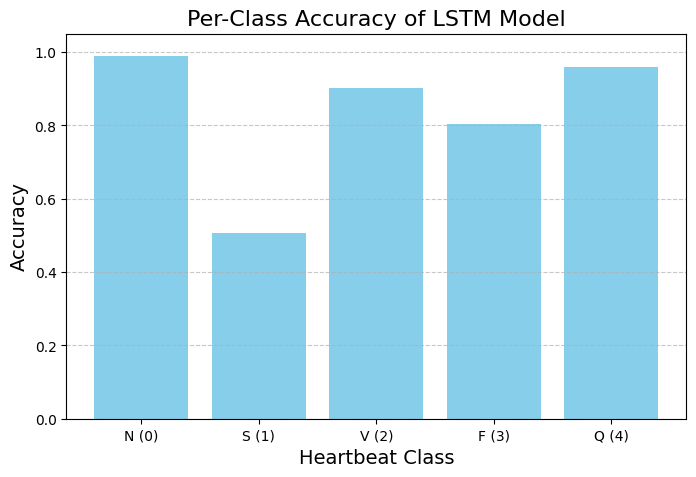

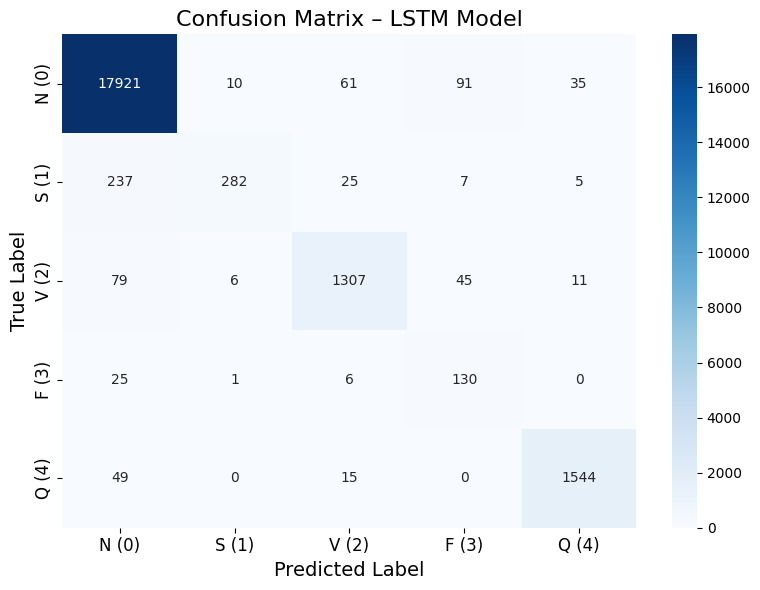

In [2]:
#  Install Kaggle & Download Dataset
!pip install kaggle -q
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip


#  Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau

#  Load Dataset
df = pd.read_csv("mitbih_train.csv", header=None)
df_test = pd.read_csv("mitbih_test.csv", header=None)

X_train = df.iloc[:, :-1].values
y_train = df.iloc[:, -1].values
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

#  Normalize Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

#  Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

#  Compile Model with Optimizer & Learning Rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Learning Rate Scheduler (Reduces LR when loss plateaus)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

#  Train Model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), callbacks=[lr_scheduler])

#  Evaluate Model
lstm_pred = np.argmax(model.predict(X_test), axis=1)
lstm_acc = np.mean(lstm_pred == y_test)
print(f"LSTM Test Accuracy: {lstm_acc:.4f}")

#  Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("LSTM Accuracy")
plt.show()



from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, lstm_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, lstm_pred)
print("\nConfusion Matrix:")
print(cm)

# Per-Class Accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc:.4f}")

# Plot Per-Class Accuracy
plt.figure(figsize=(8, 5))
classes = ['N (0)', 'S (1)', 'V (2)', 'F (3)', 'Q (4)']
plt.bar(classes, class_accuracy, color='skyblue')
plt.ylim(0, 1.05)
plt.title('Per-Class Accuracy of LSTM Model', fontsize=16)
plt.xlabel('Heartbeat Class', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix – LSTM Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()